# PySpark 101

## Learning Objectives
- Learn what is Spark and what use cases it is good for
- Learn the key components in Spark's high level architecture
- Understand what a DAG is and it's relevance to Spark applications
- Understand the difference between transformations and actions
- Learn how to write spark transformations using spark's native functions and using spark sql

## What is Spark? Why use it?
Spark is a general purpose distributed data processing engine designed to scale to large data volumes. Spark distributes your data across multiple machines (called nodes) so that they can be processed in parallel. 

Spark advantages:
- Speed
- Spark applications can be written in Scala, Java, Python, R, or SQL


# Spark High Level Architecture
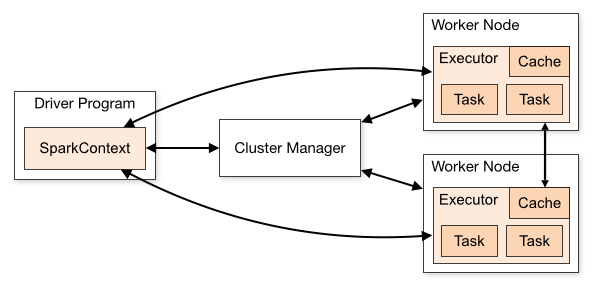

# Key Concepts and Terminology

### Spark Applications and Jobs

In Spark, applications are executed as independent sets of processes that run on a cluster of machines (also referred to as "nodes"). There is a “driver” program that submits a user’s code to the Spark cluster and converts it into a set of multiple tasks. These tasks are submitted to "executor" processes that run on separate nodes in the Spark cluster. 

A Spark application is a user built program that consists of a driver and that driver’s associated executors. A Spark job is task or set of tasks to be executed with executor processes, as directed by the driver.

Refer to the "Cluster Mode Overview" page in Spark's documentation for more details: https://spark.apache.org/docs/latest/cluster-overview.html
  
### RDD

This is the core data abstraction and building block in Spark. It stands for Resilient Distributed Dataset. A RDD is merely an immutable collection of data that is distributed and stored either in memory or on disk across a cluster of machines. Each RDD keeps track of it's data lineage (data sources and transformations that it is dependent on) so that they can be recovered in case of failures.  
    
### Dataframe

Dataframes are similar to RDDs in that they are also distributed collections of data but they differ in that they are organized into named columns (logically equivalent to a table in a relational database or a dataframe in pandas / R).  Spark uses the information of the data's structure to perform extra optimizations under the hood that greatly improve processing performance compared to RDDs. 

Refer to Spark SQL and Dataframes documentation page for more details: https://spark.apache.org/docs/latest/sql-programming-guide.html
    

### Transformations vs. Actions

RDDs and Dataframes support two types of operations: transformations and actions. Transformations create new RDDs and Dataframes from existing ones and actions return a result or value back to the driver program from computations processed on the executors. Transformations are lazily evaluated - i.e. - they are only executed when a result needs to be materialized. Spark keeps track of all the transformations needed to materialize a given RDD or Dataframe and when an action like count(), show(), or write() is executed on that object, Spark then executes only the transformations needed to materialize the result.

Refer to the sections "Transformations" and "Actions" on the RDD Programming guide for more details: https://spark.apache.org/docs/latest/rdd-programming-guide.html

### Data Sources / Sinks

Spark can read and write data from and to a variety of sources:

- csv
    - spark.read.csv()
    - df.write.csv()
- text
    - spark.read.text()
    - df.write.text()
- json
    - spark.read.json()
    - df.write.json()
- parquet
    - spark.read.parquet()
    - df.write.parquet()
- avro
    - spark.read.avro()
    - df.write.avro()
    
See more here: https://spark.apache.org/docs/latest/sql-data-sources.html

In [2]:
# Note: open this notebook in a "conda_python3" kernel
import sagemaker_pyspark
from pyspark.sql import SparkSession
classpath = ":".join(sagemaker_pyspark.classpath_jars())
spark = (
    SparkSession.builder
    .config("spark.driver.extraClassPath", classpath)
    .config("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")
).getOrCreate()

In [2]:
# This is your Spark Session which is your entry point to the Spark application
spark

# Spark Transformation Examples
Link to Documentation: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html

## Load dataset and create temporary spark table

In [3]:
# Load dataframe
df = spark.read.option("header", "True").csv("s3a://covid19-lake/static-datasets/csv/countrycode/")

# Register dataframe as a temporary spark table so that we can use spark.sql
df.createOrReplaceTempView("country_code_qs")

In [4]:
# check schema of dataset
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Alpha-2 code: string (nullable = true)
 |-- Alpha-3 code: string (nullable = true)
 |-- Numeric code: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [5]:
# print number of records in dataset
df.count()

256

## Select subset of columns from dataset

In [6]:
# create a new dataframe with a subset of columns

# using native spark transformations
subset_df_native = df.select("Country", "Latitude", "Longitude")

# using spark sql 
subset_df_sql = spark.sql("select Country, Latitude, Longitude from country_code_qs")

# uncomment to print first 20 rows of the newly created dataframes - notice the difference in execution time (show() is an action)
# subset_df_native.show()
# subset_df_sql.show()

## Select distinct values 

In [7]:
# create a new dataframe with the distinct list of countries

# using native spark transformations
distinct_countries_native = df.select("Country").distinct()

# using spark sql
distinct_countries_sql = spark.sql("select distinct Country from country_code_qs")

# uncomment to print first 20 rows of the newly created dataframes
# distinct_countries_native.show()
# distinct_countries_sql.show()

## Filter dataset

In [8]:
# create a new dataframe that only has entries for China

# using native spark transformations
china_df_native = df.where("Country = 'China'")

# using spark sql
china_df_sql = spark.sql("select * from country_code_qs where Country = 'China'")

# uncomment to print first 20 rows of the newly created dataframes
# china_df_native.show()
# china_df_sql.show()

## Group By, Aggregate, and Order By

In [10]:
# create a new dataframe that has the count per country ordered by count ascending

# using native spark transformations
from pyspark.sql import functions as f
country_count_df_native = df.groupby("Country").agg(f.count(f.lit(1)).alias("country_count")).orderBy("country_count")

# using spark sql
sql_query = """select Country, count(1) as country_count 
               from country_code_qs 
               group by Country 
               order by country_count"""
country_count_df_sql = spark.sql(sql_query)

# uncomment to print first 20 rows of the newly created dataframes
# country_count_df_native.show()
# country_count_df_sql.show()

+--------------------+-------------+
|             Country|country_count|
+--------------------+-------------+
|       Côte d'Ivoire|            1|
|                Chad|            1|
|            Anguilla|            1|
|            Paraguay|            1|
|              Russia|            1|
|               Macao|            1|
|British Indian Oc...|            1|
|               Yemen|            1|
|Heard Island and ...|            1|
|Congo, the Democr...|            1|
|             Senegal|            1|
|French Southern T...|            1|
|            Kiribati|            1|
|              Sweden|            1|
|             Tokelau|            1|
|              Guyana|            1|
|Svalbard and Jan ...|            1|
|             Eritrea|            1|
|              Jersey|            1|
|               Burma|            1|
+--------------------+-------------+
only showing top 20 rows



## Joins

In [11]:
# join example

# load county population dataset
county_pop_df = spark.read.option("header", "True").csv("s3a://covid19-lake/static-datasets/csv/CountyPopulation/")

# load states abbreviation dataset
state_abv_df = spark.read.option("header", "True").csv("s3a://covid19-lake/static-datasets/csv/state-abv/")

# register dataframes as temporary spark tables so that we can use spark sql
county_pop_df.createOrReplaceTempView("county_pop")
state_abv_df.createOrReplaceTempView("state_abv")

In [12]:
# check schemas of datasets

county_pop_df.printSchema()
state_abv_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Id2: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Population Estimate 2018: string (nullable = true)

root
 |-- State: string (nullable = true)
 |-- Abbreviation: string (nullable = true)



In [14]:
# (inner) join datasets by State

# using native spark transformations
joined_df_native = county_pop_df.join(state_abv_df, county_pop_df['State'] == county_pop_df['State'], how='inner')

# using spark sql
joined_df_sql = spark.sql("select * from county_pop a inner join state_abv b on a.State = b.State")

# uncomment to print first 20 rows of the newly created dataframes
# joined_df_native.show()
# joined_df_sql.show()

+--------------+----+---------+-------+------------------------+-------+------------+
|            Id| Id2|   County|  State|Population Estimate 2018|  State|Abbreviation|
+--------------+----+---------+-------+------------------------+-------+------------+
|0500000US01001|1001|  Autauga|Alabama|                   55601|Alabama|          AL|
|0500000US01003|1003|  Baldwin|Alabama|                  218022|Alabama|          AL|
|0500000US01005|1005|  Barbour|Alabama|                   24881|Alabama|          AL|
|0500000US01007|1007|     Bibb|Alabama|                   22400|Alabama|          AL|
|0500000US01009|1009|   Blount|Alabama|                   57840|Alabama|          AL|
|0500000US01011|1011|  Bullock|Alabama|                   10138|Alabama|          AL|
|0500000US01013|1013|   Butler|Alabama|                   19680|Alabama|          AL|
|0500000US01015|1015|  Calhoun|Alabama|                  114277|Alabama|          AL|
|0500000US01017|1017| Chambers|Alabama|               

# Hands On Exercises

In [32]:
# Load datasets
county_pop_df = spark.read.option("header", "True").csv("s3a://covid19-lake/static-datasets/csv/CountyPopulation/")
state_abv_df = spark.read.option("header", "True").csv("s3a://covid19-lake/static-datasets/csv/state-abv/")
testing_data_df = spark.read.option("header", "True").csv("s3a://covid19-lake/rearc-covid-19-testing-data/csv/states_daily/")

# Register as temporary tables
county_pop_df.createOrReplaceTempView("county_pop")
state_abv_df.createOrReplaceTempView("state_abv")
testing_data_df.createOrReplaceTempView("testing_data")

In [33]:
# Inspect schemas of datasets
county_pop_df.printSchema()
state_abv_df.printSchema()
testing_data_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Id2: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Population Estimate 2018: string (nullable = true)

root
 |-- State: string (nullable = true)
 |-- Abbreviation: string (nullable = true)

root
 |-- date: string (nullable = true)
 |-- state: string (nullable = true)
 |-- positive: string (nullable = true)
 |-- negative: string (nullable = true)
 |-- pending: string (nullable = true)
 |-- hospitalizedCurrently: string (nullable = true)
 |-- hospitalizedCumulative: string (nullable = true)
 |-- inIcuCurrently: string (nullable = true)
 |-- inIcuCumulative: string (nullable = true)
 |-- onVentilatorCurrently: string (nullable = true)
 |-- onVentilatorCumulative: string (nullable = true)
 |-- recovered: string (nullable = true)
 |-- hash: string (nullable = true)
 |-- dateChecked: string (nullable = true)
 |-- death: string (nullable = true)
 |-- hospitalized: string (nullable = true)
 |

In [40]:
# Create a dataframe with only the County, State, and Population columns from county_pop_df and print first 20 rows

# Your code here:


In [39]:
# Create a dataframe with the total population estimate per State from county_pop_df and print first 20 rows
# hint: use "Population Estimate 2018" - to reference this column in spark.sql use tick marks (`) since this column name contains spaces
#    - i.e. - spark.sql("select `Population Estimate 2018` from county_pop")

# Your code here:


In [38]:
# Create the same dataframe above but replace State with its abbreviation by joining to state_abv_df and print first 20 rows

# Your code here:


In [50]:
# Print number of distinct dates in testing_data_df

# Your code here:


In [ ]:
# Print number of records in testing_data_df for month of April

# Your code here:


In [ ]:
# Create a dataframe with the sum of total tests* by state abbreviation for the month of April and print first 20 rows
# * use "total" from testing_data_df

# Your code here:

In [55]:
# Create a dataframe with the following columns:
#    date,
#    percentage of positives tests,
#    percentage of negative tests

# Your code here:


In [56]:
# Create a dataframe with the following columns: 
#    date, 
#    state abbreviation, 
#    total tests as a percentage of the state's population* 
#    total deaths as a percentage of the state's population*
#
# * hint: use "total" and "deaths" from testing_data_df and "Population Estimate 2018" from county_pop_df


# Your code here:
